In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense,BatchNormalization,LSTM,TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
import os


In [28]:

# features = np.load('model_artifacts/normalized_features.npy')
# labels = np.load('model_artifacts/encoded_labels.npy')

# # Convert labels to one-hot encoding
# labels_onehot = to_categorical(labels)

artifacts_path='E:/final year project/model_artifacts'

normalisied_features=np.load(os.path.join(artifacts_path,'normalized_features.npy') )
emotion_oneHot=np.load(os.path.join(artifacts_path,'encoded_labels.npy'))
print(emotion_oneHot)

# joblib.dump(scaler, os.path.join(artifacts_path,'minmax_scaler.pkl'))
# joblib.dump(label_encoder, os.path.join(artifacts_path,'label_encoder.pkl'))

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    normalisied_features.squeeze(), emotion_oneHot, test_size=0.2, random_state=42
)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



(13440, 1, 168) (3360, 1, 168) (13440, 7) (3360, 7)


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Lambda, Dropout, Reshape, BatchNormalization, Input, TimeDistributed,Bidirectional

# Define the AttentionLayer class
class ExpandDimsLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.expand_dims(inputs, axis=1)
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Define trainable weights
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1],), initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-2],), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Compute attention scores
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        # Compute attention weights
        a = tf.nn.softmax(e, axis=1)
        # Compute weighted sum of inputs
        return tf.reduce_sum(x * tf.expand_dims(a, -1), axis=1)

# Define the model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], 1))  # Use explicit shape

# Convolutional layers
x = Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((1, 2), padding='same')(x)
x = Dropout(0.2)(x)

x = Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((1, 2), padding='same')(x)
x = Dropout(0.3)(x)

# Flatten and dense layers
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# Add time dimension for LSTM
x = ExpandDimsLayer()(x)

# LSTM layers
x = Bidirectional(LSTM(256, return_sequences=True))(x)

x = Bidirectional(LSTM(128, return_sequences=True))(x)
# Attention layer
x = AttentionLayer()(x)

# Final dense layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(7, activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=out)






# # 1st CNN Block
# model.add(Conv2D(32, kernel_size=5, strides=(1,1), activation='relu', input_shape=(1, 168, 1)))  # Fixed input_shape
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(1,2)))

# # 2nd CNN Block
# model.add(Conv2D(64, kernel_size=3, strides=(1,1), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(1,2)))

# # 3rd CNN Block
# model.add(Conv2D(128, kernel_size=3, strides=(1,1), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(1,2)))

# # Flatten CNN Output
# model.add(TimeDistributed(Flatten()))

# # LSTM Layers
# model.add(LSTM(128, return_sequences=True))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dropout(0.3))

# # Fully Connected Layers
# model.add(Dense(256, activation='relu'))
# model.add(Dense(6, activation='softmax'))  # Assuming 6 emotion classes

# # Compile Model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


In [31]:
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [32]:
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        cce = CategoricalCrossentropy()
        cross_entropy = cce(y_true, y_pred)
        pt = tf.exp(-cross_entropy)
        focal_loss = alpha * (1 - pt) ** gamma * cross_entropy
        return focal_loss
    return loss_fn

In [33]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

from tensorflow.keras.callbacks import LearningRateScheduler

def clr_schedule(epoch, lr):
    min_lr = 1e-5
    max_lr = 5e-4
    cycle = 15
    return min_lr + (max_lr - min_lr) * abs((epoch % (2 * cycle)) - cycle) / cycle

clr_callback = LearningRateScheduler(clr_schedule)

In [34]:
from tensorflow.keras import metrics
model.compile(optimizer=Adam(learning_rate=0.001), loss=focal_loss(), metrics=['accuracy', metrics.Precision(), metrics.Recall()])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1, 168, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 168, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 168, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 84, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 84, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 1, 84, 64)           │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 84, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         688,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expand_dims_layer (ExpandDimsLayer)  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 1, 512)              │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 1, 256)              │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 256)                 │             257 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,481,928 (9.47 MB)

 Trainable params: 2,481,736 (9.47 MB)

 Non-trainable params: 192 (768.00 B)

In [35]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=128, callbacks=[lr_schedule])

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - accuracy: 0.5744 - loss: 0.1537 - precision_1: 0.7922 - recall_1: 0.3851 - val_accuracy: 0.1515 - val_loss: 0.3500 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.8871 - loss: 0.0055 - precision_1: 0.9285 - recall_1: 0.8529 - val_accuracy: 0.1789 - val_loss: 0.3687 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.9228 - loss: 0.0022 - precision_1: 0.9502 - recall_1: 0.9019 - val_accuracy: 0.2786 - val_loss: 0.3729 - val_precision_1: 0.4194 - val_recall_1: 0.0426 - learning_rate: 0.0010
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.9336 - loss: 0.0014 - precision_1: 0.9527 - recall_1: 0.9138 - val_accuracy: 0.3958 - val_loss: 0.2924 - val_precision_1: 0.4630 - val_recall_1: 0.3628 - learning_rate: 0.0010
Epoc

In [36]:
loss, accuracy,precision_1,recall_1 = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9916 - loss: 3.9719e-05 - precision_1: 0.9923 - recall_1: 0.9904
Test Loss: 2.150479849660769e-05
Test Accuracy: 0.9940476417541504


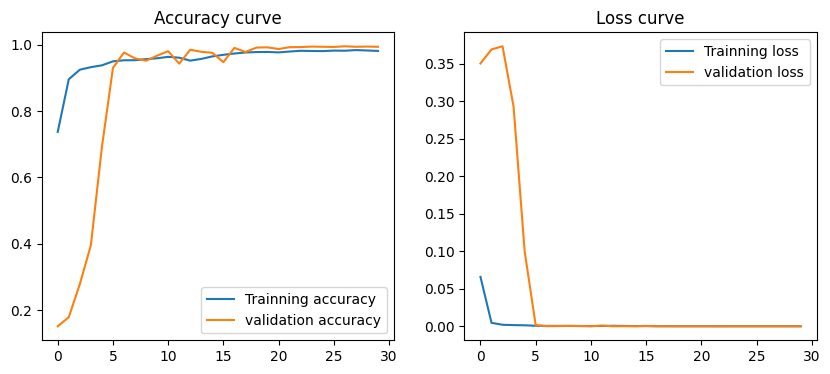

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='Trainning accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.title("Accuracy curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Trainning loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title("Loss curve")
plt.legend()


In [38]:
import joblib
import pandas as pd
pred=model.predict(X_test)
print(pred)
y_pred=np.argmax(pred,axis=1)
y_pred_classes=np.argmax(y_test,axis=1)
scaler = joblib.load(os.path.join(artifacts_path,'minmax_scaler.pkl'))
label_encoder = joblib.load(os.path.join(artifacts_path,'label_encoder.pkl'))


y_pred_labels=label_encoder.inverse_transform(y_pred)
y_test_labels=label_encoder.inverse_transform(y_pred_classes)
df_pred = pd.DataFrame({
    'Predicted Labels': y_pred_labels,
    'Actual Labels': y_test_labels
})


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
[[9.57974635e-07 7.59402928e-06 5.53381426e-07 ... 2.35995810e-08
  4.93607729e-07 4.01759917e-06]
 [4.19080123e-07 6.17662363e-06 1.15556304e-07 ... 9.99982715e-01
  6.78359083e-06 3.67770076e-06]
 [8.61542844e-07 1.64678742e-04 1.04731885e-06 ... 1.03684379e-05
  9.99822080e-01 5.99761847e-07]
 ...
 [3.27499697e-06 9.52876803e-07 9.99987364e-01 ... 1.95441014e-08
  1.40968950e-07 4.58945294e-07]
 [5.89113097e-06 3.51316686e-07 9.99992490e-01 ... 9.43248057e-09
  1.25847137e-07 6.79546659e-08]
 [5.74643946e-06 5.86952883e-05 1.20691368e-07 ... 4.18023035e-07
  9.18749663e-08 9.99921441e-01]]


In [39]:
df_pred[1:20]

,Predicted Labels,Actual Labels
1,Neutral,Neutral
2,Sad,Sad
3,Surprised,Surprised
4,Disgust,Disgust
5,Fear,Fear
6,Surprised,Surprised
7,Disgust,Disgust
8,Happy,Happy
9,Happy,Happy
10,Fear,Fear


In [40]:
model.save(filepath=f"E:/final year project/models/model_latest_{accuracy:.2f}.keras")
# model.save_weights(filepath=f"E:/final year project/models/model_{accuracy:.2f}.weights.h5")

In [41]:
model.output_shape

(None, 7)